## IS453 Financial Analytics
## Week 10 - Credit Scoring Lab Data

### Grouping and Screening

## HMEQ Dataset

The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. 
The data is originally taken from the Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS book website - https://www.bartbaesens.com/book/6/credit-risk-analytics.
A cleaner version of the data is on Kaggle - https://www.kaggle.com/akhil14shukla/loan-defaulter-prediction/data


**Variables definition**

1. BAD: Binary response variable
    - 1 = applicant defaulted on loan or seriously delinquent; 
    - 0 = applicant paid loan or customer is current on loan payments. This is the class column.
2. LOAN: Requested loan amount
3. MORTDUE: Amount due on existing mortgage
4. VALUE: Value of current property
5. REASON: 
    - DebtCon = debt consolidation(customer uses home equity loan to pay back high interest loans)
    - HomeImp = home improvement
6. JOB: Occupational categories
    - ProfExe
    - Mgr
    - Office
    - Self
    - Sales
    - Other
7. YOJ: Years at present job
8. DEROG: Number of major derogatory reports(issued for loans taken in the past when customer fails to keep up the contract or payback on time).
9. DELINQ: Number of delinquent credit lines
10. CLAGE: Age of oldest credit line in months
11. NINQ: Number of recent credit inquiries
12. CLNO: Number of credit lines
13. DEBTINC: Debt-to-income ratio in percent

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
hmeq_data = pd.read_csv('hmeq_data.csv')

hmeq_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


## 1. Fine classing

**Use pd.qcut to divide numeric variables into quantile ranges**

** Split the CLAGE variale data into 20 groups using equal frequency binning using qcut**

**Assign the bins from qcut output to the original dataframe**


In [5]:
# sample code
bin_count = 20
variable = 'CLAGE'

# create a copy to work on
hmeq_data_working = hmeq_data.copy() 

# reduce to just the variable and the target
hmeq_data_working = hmeq_data_working[[variable, 'BAD']]

# create equal frequency bin ranges using qcut
hmeq_data_working['Bin_Range'] = pd.qcut(hmeq_data[variable],q=bin_count, precision=0)

# missing values have been assigned NaN when binning with pd.qcut 
# rename NaN to 'Missing' and create bin range for those
hmeq_data_working['Bin_Range'] = hmeq_data_working['Bin_Range'].astype('object')
hmeq_data_working['Bin_Range'].fillna('Missing', inplace = True)

# check the counts in each bin
hmeq_data_working.groupby('Bin_Range').count()


,CLAGE,BAD
Bin_Range,,
"(-1.0, 69.0]",283,283
"(69.0, 85.0]",283,283
"(85.0, 95.0]",282,282
"(95.0, 106.0]",283,283
"(106.0, 115.0]",282,282
"(115.0, 123.0]",283,283
"(123.0, 132.0]",282,282
"(132.0, 145.0]",283,283
"(145.0, 160.0]",283,283


In [6]:
# check the number of bads in each bin
hmeq_data_working.groupby('Bin_Range').sum().loc[:, 'BAD']

Bin_Range
(-1.0, 69.0]       114
(69.0, 85.0]        81
(85.0, 95.0]        75
(95.0, 106.0]       71
(106.0, 115.0]      65
(115.0, 123.0]      82
(123.0, 132.0]      62
(132.0, 145.0]      76
(145.0, 160.0]      66
(160.0, 173.0]      58
(173.0, 182.0]      39
(182.0, 193.0]      44
(193.0, 204.0]      41
(204.0, 216.0]      44
(216.0, 232.0]      44
(232.0, 247.0]      33
(247.0, 268.0]      31
(268.0, 296.0]      25
(296.0, 322.0]      30
(322.0, 1168.0]     30
Missing             78
Name: BAD, dtype: int64

## 2. Calculate WOE and IV for classed variable

**Calculate the number of events and non-events in each bin (default vs non-default)**

We are going to create a binning table.

Create a new dataframe with these columns:

1. Bin_Range

2. Count = total number of people that belong to this bin

3. Events = number of people that defaulted in this bin

4. Non_Events = number of that people that paid off the loan in this bin

5. %_of_Events

6. %_of_Non_Events

7. WOE

8. IV




In [7]:
# sample code 

# create new dataframe for variable WOE and IV calcs
variable_data = pd.DataFrame()

# create initial column with bin ranges
variable_data['Bin_Range'] = hmeq_data_working.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

variable_data

,Bin_Range
0,"(-1.0, 69.0]"
1,"(69.0, 85.0]"
2,"(85.0, 95.0]"
3,"(95.0, 106.0]"
4,"(106.0, 115.0]"
5,"(115.0, 123.0]"
6,"(123.0, 132.0]"
7,"(132.0, 145.0]"
8,"(145.0, 160.0]"
9,"(160.0, 173.0]"


In [8]:
# sample code 

# add count, num events, and num non-events
variable_data['Count'] = hmeq_data_working.groupby(by='Bin_Range', as_index=False).count()['BAD']

variable_data['Events'] = hmeq_data_working.groupby(by='Bin_Range', as_index=False).sum()['BAD']

variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

variable_data

,Bin_Range,Count,Events,Non_Events
0,"(-1.0, 69.0]",283,114,169
1,"(69.0, 85.0]",283,81,202
2,"(85.0, 95.0]",282,75,207
3,"(95.0, 106.0]",283,71,212
4,"(106.0, 115.0]",282,65,217
5,"(115.0, 123.0]",283,82,201
6,"(123.0, 132.0]",282,62,220
7,"(132.0, 145.0]",283,76,207
8,"(145.0, 160.0]",283,66,217
9,"(160.0, 173.0]",283,58,225


In [9]:
# sample code 

# add columns with WOE calculations
variable_data['%_of_Events'] = variable_data['Events'] / sum(variable_data['Events'])

variable_data['%_of_Non_Events'] = variable_data['Non_Events'] / sum(variable_data['Non_Events'])

variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']

variable_data

,Bin_Range,Count,Events,Non_Events,%_of_Events,%_of_Non_Events,WOE,IV
0,"(-1.0, 69.0]",283,114,169,0.095879,0.035422,-0.995743,0.060199
1,"(69.0, 85.0]",283,81,202,0.068124,0.042339,-0.475625,0.012264
2,"(85.0, 95.0]",282,75,207,0.063078,0.043387,-0.374213,0.007369
3,"(95.0, 106.0]",283,71,212,0.059714,0.044435,-0.295537,0.004515
4,"(106.0, 115.0]",282,65,217,0.054668,0.045483,-0.183933,0.001689
5,"(115.0, 123.0]",283,82,201,0.068966,0.042130,-0.492858,0.013226
6,"(123.0, 132.0]",282,62,220,0.052145,0.046112,-0.122950,0.000742
7,"(132.0, 145.0]",283,76,207,0.063919,0.043387,-0.387458,0.007955
8,"(145.0, 160.0]",283,66,217,0.055509,0.045483,-0.199201,0.001997
9,"(160.0, 173.0]",283,58,225,0.048780,0.047160,-0.033786,0.000055


**Encapsulate the code in a function so it can be rerun**

In [10]:
# sample code

def woe_iv(data, variable_name):

    working_data = data.copy() 

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace = True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['BAD']

    variable_data['Events'] =working_data.groupby(by='Bin_Range', as_index=False).sum()['BAD']

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events']/sum(variable_data['Events'])

    variable_data['%_of_Non_Events'] = variable_data['Non_Events']/sum(variable_data['Non_Events'])
    variable_data

    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

    variable_data['IV'] = (variable_data['%_of_Non_Events']-variable_data['%_of_Events']) * variable_data['WOE']

    IV = sum(variable_data['IV'])
    return(IV, variable_data)

# test the function
woe_bin_data = hmeq_data.loc[:,('CLAGE', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['CLAGE'],q=10)
woe_iv(woe_bin_data, 'CLAGE')

(0.23064099109529362,
               Bin_Range  Count  Events  Non_Events  %_of_Events  \
 0      (-0.001, 84.554]    566     195         371     0.164003   
 1     (84.554, 105.769]    565     146         419     0.122792   
 2    (105.769, 122.821]    565     147         418     0.123633   
 3    (122.821, 145.101]    565     138         427     0.116064   
 4    (145.101, 173.467]    566     124         442     0.104289   
 5    (173.467, 193.104]    564      83         481     0.069807   
 6    (193.104, 215.709]    565      85         480     0.071489   
 7    (215.709, 247.087]    565      77         488     0.064760   
 8    (247.087, 295.716]    565      56         509     0.047098   
 9   (295.716, 1168.234]    566      60         506     0.050463   
 10              Missing    308      78         230     0.065601   
 
     %_of_Non_Events       WOE        IV  
 0          0.077761 -0.746241  0.064357  
 1          0.087822 -0.335179  0.011721  
 2          0.087613 -0.344394 

**Ex Q1. Compute Information Value for the CLAGE characteristic**

What is the IV, rounded to 4 decimal places, using 20 bins? 

Run again with the number of bins set to 10 and recalculate the IV. Which is higher? 

Why do you think that is the case?

In [11]:
# your code here

woe_bin_data = hmeq_data.loc[:,('CLAGE', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['CLAGE'],q=10)
print(woe_iv(woe_bin_data, 'CLAGE')[0])

woe_bin_data = hmeq_data.loc[:,('CLAGE', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['CLAGE'],q=20)
print(woe_iv(woe_bin_data, 'CLAGE')[0])

0.23064099109529362
0.24777715351807875


- IV with 10 bins: 0.2306
- IV with 20 bins: 0.2478
- IV with 20 bins is higher likely due to granularity of the data.


**Plot the WOE and the bin counts** 

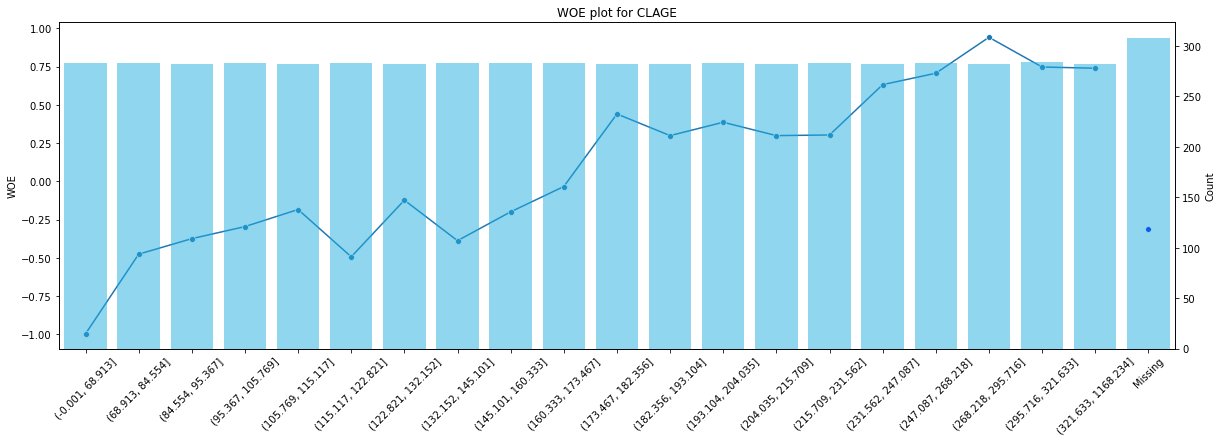

In [12]:
# sample code
variable = 'CLAGE'

woe_bin_data = hmeq_data.loc[:,(variable, 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data[variable],q=20)
variable_data = woe_iv(woe_bin_data, variable)[1]

# set up plots
ffig, ax1 = plt.subplots(figsize=(20,6))

sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
plt.xticks(rotation=45)

# Create the scatter plot to plot the Missing WOE data point
last_point = len(variable_data['WOE']) - 1
scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)

ax2 = ax1.twinx()

# plot the bin counts
sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')

plt.title("WOE plot for " + variable)
plt.show()

**Create function to calculate WOE, IV and plot IV**

Combine the code above into a parameterised function that you can use going forward to print IV rounded to 4 decimal places and plot WOE.

IV for CLAGE with 21 bins: 0.2478


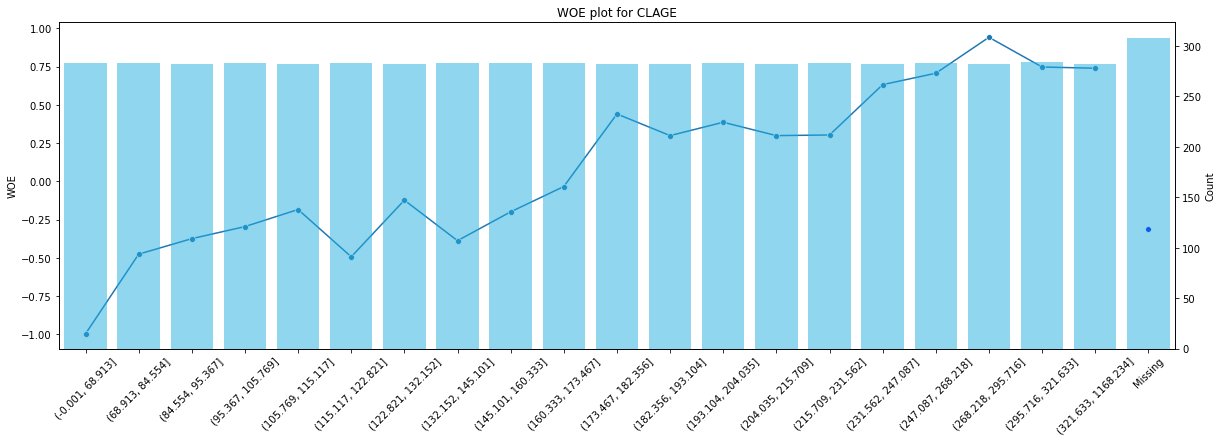

In [13]:
# sample code

# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    IV, variable_data = woe_iv(data, variable_name)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(IV,4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot

    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
        
    # plot the bin counts
    sns.barplot(x = variable_data['Bin_Range'] , y = variable_data['Count'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    plt.title("WOE plot for " + variable_name)
    plt.show()
    
# test the function
woe_bin_data = hmeq_data.loc[:,('CLAGE', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['CLAGE'],q=20)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace = True)
woe_iv_plot(woe_bin_data, 'CLAGE')

## 3. Variable screening

**Ex Q2. Calculate the IV for the large value variables: LOAN, MORTDUE, CLAGE, DEBTINC using bin_count = 20**

What are their IVs and corresponding predictive strength?  

Which variables(s) can be dropped on that basis?

*Hint: refer to the interpretation table for IV in the lecture slides*

In [14]:
# your code here

large_val_numeric = ['LOAN', 'MORTDUE', 'CLAGE', 'DEBTINC']
# add code to obtain IV for each of the variables
woe_bin_data = hmeq_data.loc[:,('LOAN', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['LOAN'],q=20)
print("LOAN IV: ", woe_iv(woe_bin_data, 'LOAN')[0])

woe_bin_data = hmeq_data.loc[:,('MORTDUE', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['MORTDUE'],q=20)
print("MORTDUE IV: ", woe_iv(woe_bin_data, 'MORTDUE')[0])

woe_bin_data = hmeq_data.loc[:,('CLAGE', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['CLAGE'],q=20)
print("CLAGE IV: ", woe_iv(woe_bin_data, 'CLAGE')[0])

woe_bin_data = hmeq_data.loc[:,('DEBTINC', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['DEBTINC'],q=20)
print("DEBTINC IV: ", woe_iv(woe_bin_data, 'DEBTINC')[0])

LOAN IV:  0.22698573260515517
MORTDUE IV:  0.07344071774017694
CLAGE IV:  0.24777715351807875
DEBTINC IV:  1.9990272250258383


Your answer

## 4. Coarse classing

Uses pd.cut to do coarse classing using equal width bins to calcualte IV and plot WOE


IV for CLAGE with 8 bins: 0.2323


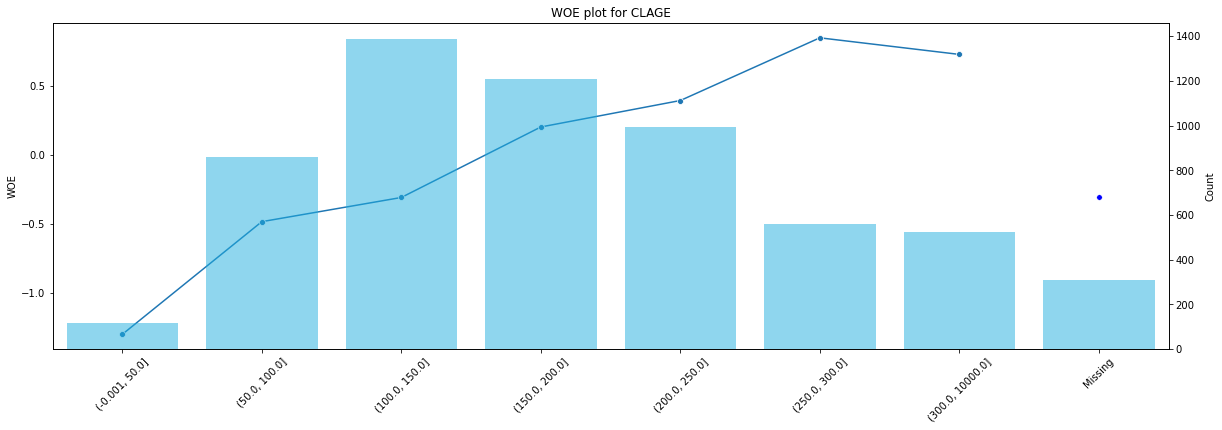

In [15]:
# sample code

bin_edges = [0, 50, 100, 150, 200, 250, 300, 10000]
variable = 'CLAGE'

# create groupings based on specified bin edges
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()

woe_iv_plot(hmeq_data_working, variable)


In [16]:
hmeq_data_working[['Bin_Range']].isin(['Missing']).sum()


Bin_Range    0
dtype: int64

**Ex Q3. Adjust the bin ranges so WOE is monotonic**

What are three issues with the WOE chart based on the default fixed interval binning approach used?

Reduce the number of bins to 5, including the 'Missing' bin, using pd.cut to address these issues.

How did the the IV change for your new binning arrangement?  Is it still in the same predictive range?

Based on its WOE value, which bin could 'Missing' be potentially combined with?

*Hint: Look at the WOE chart based on equal bins and look for groups that are at similar ranges and define the bin edges according to those groups.*

IV for CLAGE with 5 bins: 0.1734


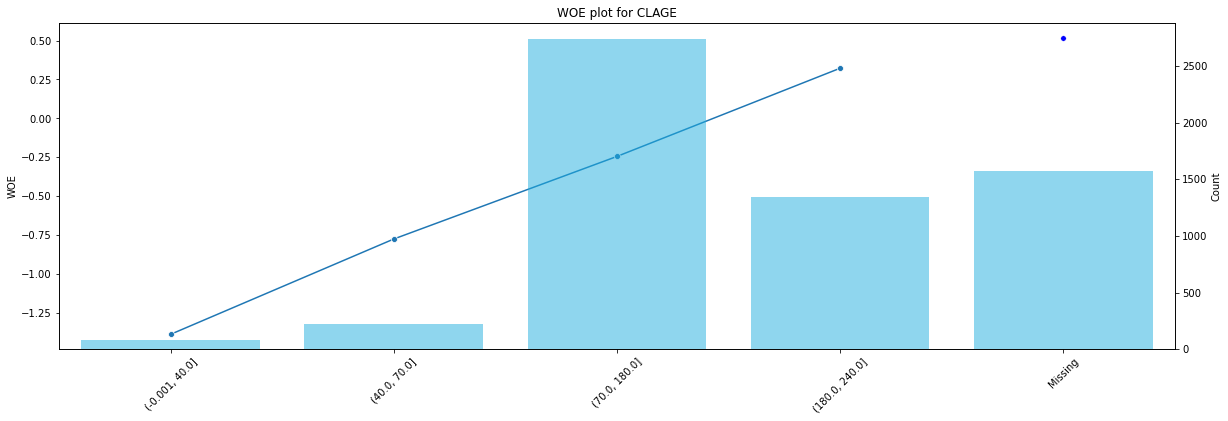

In [17]:
# your code here
# bin_edges = [0, 50, 100, 150, 200, 250, 300, 10000]
bin_edges = [0, 40, 70, 180, 240]

variable = 'CLAGE'

# create groupings based on specified bin edges
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()

woe_iv_plot(hmeq_data_working, variable)

Your answer

# DYI

**DIY Q1:**

Review the LOAN variable WOE and IV with fine classing.  Is the trend start-to-end generally monotonic or is just part of it monotonic?

Adjust the bin edges so that you have three bins for the numeric range and the WOE is monotonic for the portion that appears to have a clear trend. Define a fourth bin for the part of the range that does not fit the trend.

How did the the IV change for your new binning arrangement?  Is it still in the same predictive range?

IV for LOAN with 20 bins: 0.227


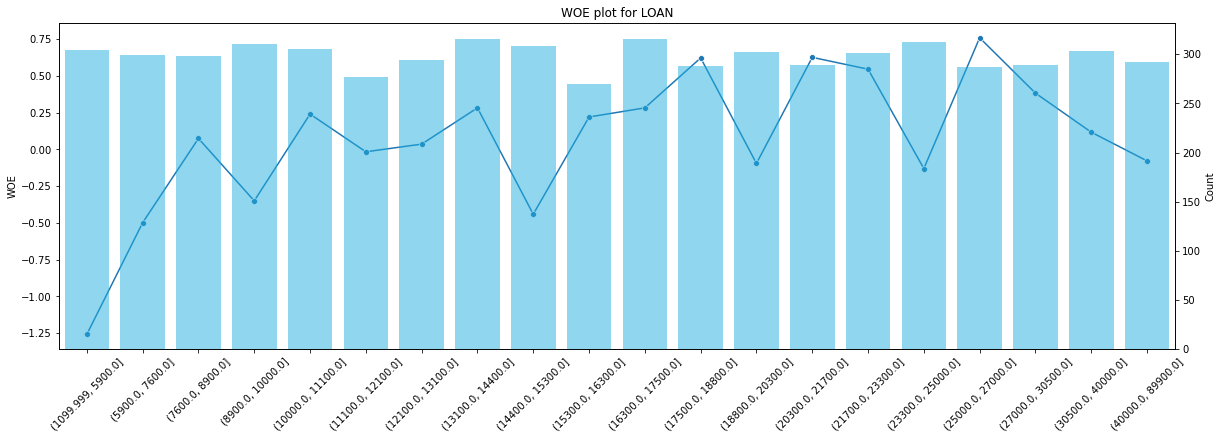

In [18]:
woe_bin_data = hmeq_data.loc[:,('LOAN', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['LOAN'],q=20)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace = True)
woe_iv_plot(woe_bin_data, 'LOAN')


IV for LOAN with 4 bins: 0.0789


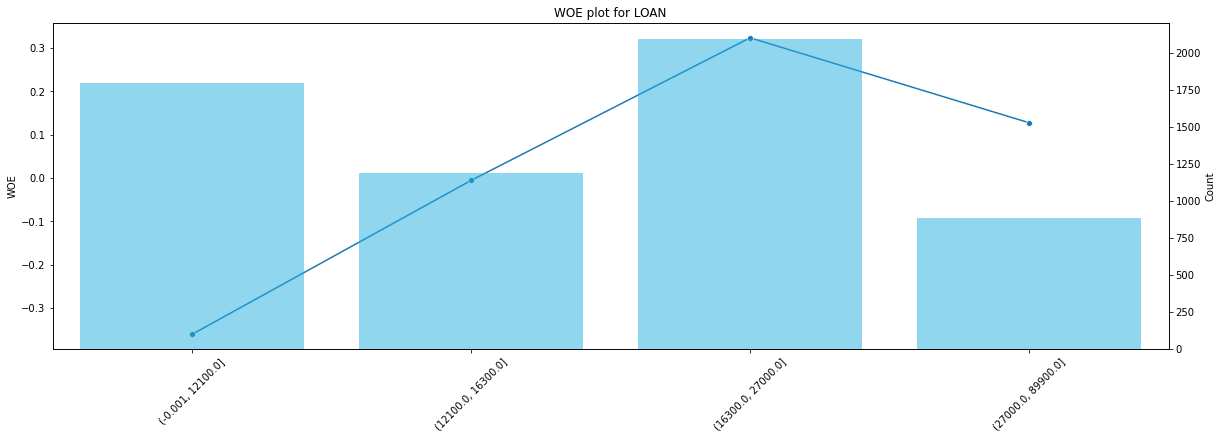

In [19]:
bin_edges = [0, 12100, 16300, 27000, 89900]
variable = 'LOAN'
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()
woe_iv_plot(hmeq_data_working, variable)



**Answer**: In fine classing, the trend is generally monotonic. However, the trend becomes no longer monotonic for the LOAN value of 27000.0 and above. Also, the coarsely classed bins are not in the same predictive range. The IV vastly dropped from 0.227 with 20 bins to 0.0789 with 4 bins. 

**DIY Q2:**

Review the DEBTINC variable WOE and IV based on fine classing.  

Is the trend start to end generally monotonic or just part of it?

Adjust the bin edges so that you have three bins for the numeric range and the WOE is monotonic for the portion that appears to have a clear trend. Define a fourth bin for the part of the range that does not fit the trend.

How did the the IV change for your new binning arrangement? Is it still in the same predictive range?

IV for DEBTINC with 21 bins: 1.999


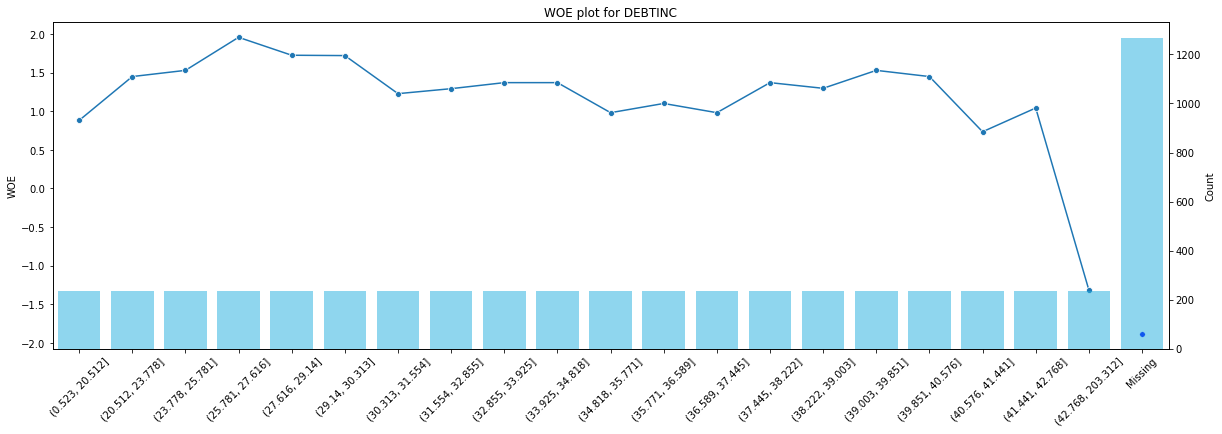

In [20]:
woe_bin_data = hmeq_data.loc[:,('DEBTINC', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['DEBTINC'],q=20)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace = True)
woe_iv_plot(woe_bin_data, 'DEBTINC')


IV for DEBTINC with 5 bins: 1.6342


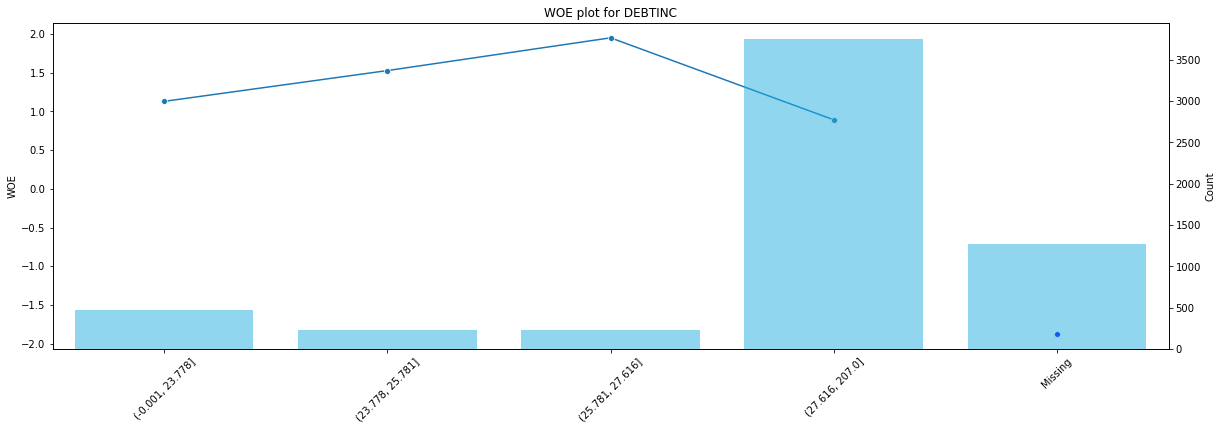

In [21]:
bin_edges = [0, 23.778, 25.781, 27.616, 207,312]
variable = 'DEBTINC'
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()
woe_iv_plot(hmeq_data_working, variable)



**Answer:** In fine classing, we can see that the trend is monotonic in some areas. However, the trend is mostly not monotonic. The IV dropped from 1.999 with 20 bins to 1.6342 with 4 bins.

**DIY Q3:**

Review the DEROG variable WOE and IV based on fine classing.  

Redefine groupings to just have two, one with negative WOE and another with positive WOE

What are bin edges?

How did the the IV change for your new binning arrangement? Is it still in the same predictive range?

Which group is the 'Missing' bin WOE the closest match to?

IV for DEROG with 6 bins: 0.2993


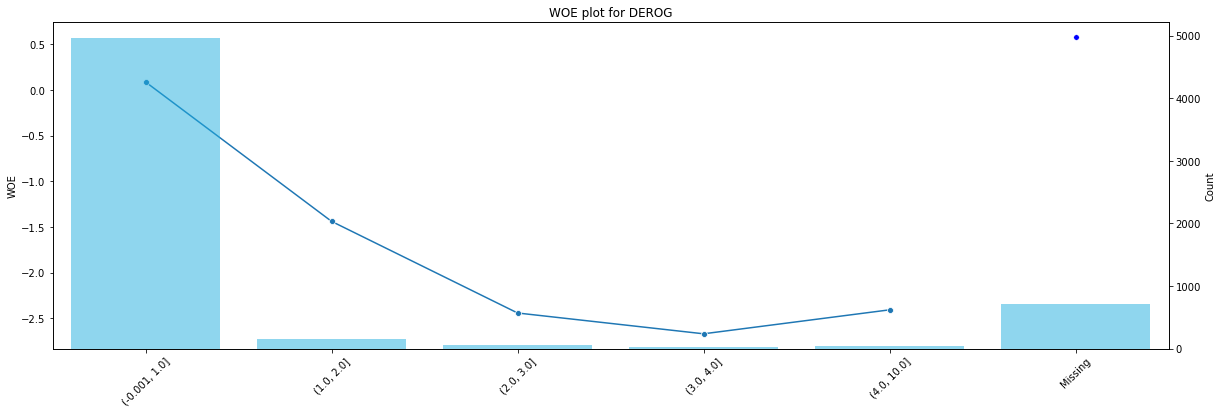

In [22]:
woe_bin_data = hmeq_data.loc[:,('DEROG', 'BAD')]
woe_bin_data['Bin_Range'] = pd.qcut(hmeq_data['DEROG'],q=100, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace = True)
woe_iv_plot(woe_bin_data, 'DEROG')

IV for DEROG with 3 bins: 0.2766


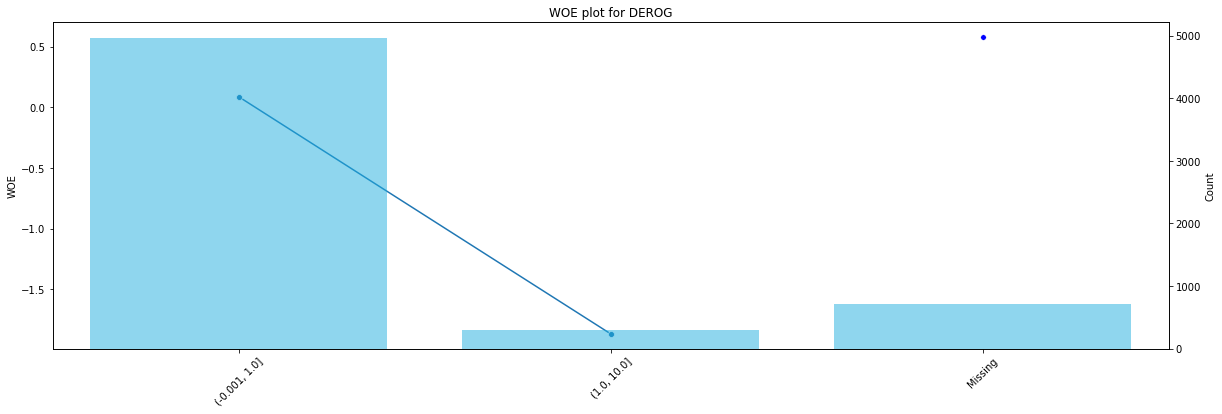

In [23]:
bin_edges = [0, 1, 10]
variable = 'DEROG'
hmeq_data_working['Bin_Range'] = pd.cut(hmeq_data[variable], bins = bin_edges, include_lowest= True)
hmeq_data_working['Bin_Range'].value_counts().sort_index()
woe_iv_plot(hmeq_data_working, variable)


**Answer:** The IV fell, but only from 0.2993 from fine classing (6 bins) to 0.2766 to coarse classing (3 bins). The 'Missing' bin's WOE is closest to the 1.0 to 10.0 range (which has a negative WOE), which suggests that BAD applicants tend to omit the number of past major derogatory reports against them. 

# Group Assignment Preparation
Do fine classing and characteristic screening on your project data.
Use the functions in the earlier part of the lab to calculate WOE and IV on a subset of your project data

**DYI Q4: Calculate IV for a subset of your variables**


Based on correlation to the target variable, pick the 30 characteristics with the highest correlation and calculate their IV

In [24]:
# your code here
app_data = pd.read_csv('IS453 Group Assignment - Application Data.csv')

In [39]:
# find 30 highest correlations, excluding SK_ID_CURR
cor = app_data.corr()['TARGET']
cor_sorted = cor.sort_values(ascending = False)[1:31]

In [46]:
# redefine function to detect 'TARGET' instead of 'BAD'
def woe_iv(data, variable_name):

    working_data = data.copy() 

    # missing values have been assigned NaN when binning with pd.qcut
    # rename this bin as 'Missing' to consider into WOE calculation
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace = True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']

    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']

    variable_data['Events'] =working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events']/sum(variable_data['Events'])

    variable_data['%_of_Non_Events'] = variable_data['Non_Events']/sum(variable_data['Non_Events'])
    variable_data

    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])

    variable_data['IV'] = (variable_data['%_of_Non_Events']-variable_data['%_of_Events']) * variable_data['WOE']

    IV = sum(variable_data['IV'])
    return(IV, variable_data)


In [50]:
for variable in cor_sorted.index:  
    woe_bin_data = app_data.loc[:, (variable, 'TARGET')]
    woe_bin_data['Bin_Range'] = pd.qcut(app_data[variable], q=20, duplicates = 'drop')
    print(variable, "IV:", woe_iv(woe_bin_data, variable)[0])


DAYS_BIRTH IV: 0.08624557614848818
REGION_RATING_CLIENT_W_CITY IV: 0.029386764767639836
REGION_RATING_CLIENT IV: 0.027649456057754408
DAYS_LAST_PHONE_CHANGE IV: inf
DAYS_ID_PUBLISH IV: 0.03969162478080394
REG_CITY_NOT_WORK_CITY IV: 0.0
FLAG_EMP_PHONE IV: 0.0
REG_CITY_NOT_LIVE_CITY IV: 0.0
FLAG_DOCUMENT_3 IV: 0.0
DAYS_REGISTRATION IV: 0.028320751591076776
OWN_CAR_AGE IV: 0.02343532623342212
LIVE_CITY_NOT_WORK_CITY IV: 0.0
DEF_30_CNT_SOCIAL_CIRCLE IV: 0.006930022145946269
DEF_60_CNT_SOCIAL_CIRCLE IV: 0.005804072015145557
FLAG_WORK_PHONE IV: 0.0
AMT_REQ_CREDIT_BUREAU_YEAR IV: 0.018153085704347788
CNT_CHILDREN IV: 0.0016690680801308942
CNT_FAM_MEMBERS IV: inf
OBS_30_CNT_SOCIAL_CIRCLE IV: 0.0032977362004346774
OBS_60_CNT_SOCIAL_CIRCLE IV: 0.0032672228867105645
REG_REGION_NOT_WORK_REGION IV: 0.0
REG_REGION_NOT_LIVE_REGION IV: 0.0
FLAG_DOCUMENT_2 IV: 0.0
FLAG_DOCUMENT_21 IV: 0.0
LIVE_REGION_NOT_WORK_REGION IV: 0.0
AMT_REQ_CREDIT_BUREAU_DAY IV: 0.013217564867983212
AMT_REQ_CREDIT_BUREAU_HOUR I

How do the variable rank in terms of their predictive power? 

*Hint: refer to IV interpretation table in the slides for module 10.2*

**Answer:** The variable with the highest IV is DAYS_BIRTH, which suggests that age is the strongest predictor of credit risk in this data set.